In [10]:
# ===========================
# KNN Regresión con CV manual 5-fold
# - One-Hot Encoding y escalado DENTRO del fold (evita data leakage)
# - Prueba k = 1..20
# - Usa tu lista de columnas categóricas
# ===========================

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

# 1) Cargar datos
df = pd.read_csv("data.csv", sep=";")

# 2) Variable objetivo (promedio de notas 1er y 2do semestre)
df["Final_Average"] = df[[
    "Curricular units 1st sem (grade)",
    "Curricular units 2nd sem (grade)"
]].mean(axis=1)

# 3) Eliminar columnas con fuga de datos (2° semestre + Target + y)
cols_to_exclude = [
    "Target", "Final_Average",
    "Curricular units 2nd sem (grade)",
    "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 2nd sem (credited)",
    "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (without evaluations)",
]
X_full = df.drop(columns=cols_to_exclude, errors="ignore").copy()
y_full = df["Final_Average"].values

# 4) Tus columnas categóricas (idénticas a clasificación)
categorical_columns = [
    'Marital status', 'Application mode', 'Application order', 'Course',
    'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
    "Mother's qualification", "Father's qualification",
    "Mother's occupation", "Father's occupation", 'Displaced',
    'Educational special needs', 'Debtor', 'Tuition fees up to date',
    'Gender', 'Scholarship holder', 'International'
]
# Usar solo las que existan (por si algún nombre difiere en tu CSV)
categorical_columns = [c for c in categorical_columns if c in X_full.columns]

# 5) Columnas numéricas CONTINUAS (antes de OHE) que se escalarán por fold
numeric_columns_pre_ohe = X_full.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_columns_pre_ohe = [c for c in numeric_columns_pre_ohe if c not in categorical_columns]

# 6) Configuración de CV manual y estructura de resultados
kf = KFold(n_splits=5, shuffle=True, random_state=42)
k_values = range(1, 21)
cv_results = {k: {"RMSE": [], "MAE": [], "R2": [], "MedAE": [], "MAPE": []} for k in k_values}

# 7) Loop de CV manual: OHE + Escalado DENTRO del fold
for k in k_values:
    for tr_idx, val_idx in kf.split(X_full):
        X_tr_raw = X_full.iloc[tr_idx].copy()
        X_val_raw = X_full.iloc[val_idx].copy()
        y_tr = y_full[tr_idx]
        y_val = y_full[val_idx]

        # --- One-Hot Encoding SOLO con las columnas categóricas (ajustado con train del fold)
        X_tr = pd.get_dummies(X_tr_raw, columns=categorical_columns, drop_first=True)
        X_val = pd.get_dummies(X_val_raw, columns=categorical_columns, drop_first=True)

        # Alinear validación a las columnas del train (categorías faltantes = 0)
        X_val = X_val.reindex(columns=X_tr.columns, fill_value=0)

        # --- Escalar SOLO numéricas continuas disponibles tras OHE (fit con train del fold)
        cols_to_scale_fold = [c for c in numeric_columns_pre_ohe if c in X_tr.columns]
        scaler = StandardScaler()
        X_tr[cols_to_scale_fold] = scaler.fit_transform(X_tr[cols_to_scale_fold])
        X_val[cols_to_scale_fold] = scaler.transform(X_val[cols_to_scale_fold])

        # --- Modelo y predicción
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_tr, y_tr)
        y_pred = knn.predict(X_val)

        # --- Métricas del fold
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_val, y_pred)
        r2  = r2_score(y_val, y_pred)
        medae = median_absolute_error(y_val, y_pred)
        eps = 1e-8  # para evitar división por cero en MAPE
        mape = np.mean(np.abs((y_val - y_pred) / (np.abs(y_val) + eps))) * 100

        cv_results[k]["RMSE"].append(rmse)
        cv_results[k]["MAE"].append(mae)
        cv_results[k]["R2"].append(r2)
        cv_results[k]["MedAE"].append(medae)
        cv_results[k]["MAPE"].append(mape)

# 8) Resumen por k (promedios de los 5 folds) y selección por RMSE
summary = []
for k in k_values:
    summary.append({
        "k": k,
        "RMSE_mean": np.mean(cv_results[k]["RMSE"]),
        "RMSE_std":  np.std(cv_results[k]["RMSE"]),
        "MAE_mean":  np.mean(cv_results[k]["MAE"]),
        "R2_mean":   np.mean(cv_results[k]["R2"]),
        "MedAE_mean":np.mean(cv_results[k]["MedAE"]),
        "MAPE_mean": np.mean(cv_results[k]["MAPE"]),
    })

summary_df = pd.DataFrame(summary).sort_values(by="RMSE_mean", ascending=True)
print("===== Resumen CV 5-fold (ordenado por RMSE promedio) =====")
print(summary_df.to_string(index=False))

best_k = int(summary_df.iloc[0]["k"])
best_rmse = float(summary_df.iloc[0]["RMSE_mean"])
print(f"\n✅ Mejor k por RMSE promedio: {best_k} (RMSE={best_rmse:.4f})")


===== Resumen CV 5-fold (ordenado por RMSE promedio) =====
 k  RMSE_mean  RMSE_std  MAE_mean  R2_mean  MedAE_mean    MAPE_mean
 9   1.679730  0.081842  1.039846 0.876763    0.654618 9.856182e+08
10   1.683860  0.080594  1.044105 0.876197    0.653193 1.053562e+09
 8   1.685886  0.083990  1.042982 0.875783    0.665716 9.450206e+08
11   1.690423  0.076802  1.048292 0.875310    0.657615 1.120849e+09
12   1.695597  0.077277  1.051116 0.874539    0.651718 1.178630e+09
14   1.699056  0.073439  1.055706 0.874157    0.652816 1.279126e+09
 7   1.699449  0.083413  1.045644 0.873799    0.673733 8.956994e+08
15   1.699449  0.074223  1.057275 0.874103    0.656791 1.316259e+09
13   1.700043  0.072951  1.054299 0.873983    0.653949 1.232105e+09
 6   1.702812  0.081453  1.048806 0.873304    0.686029 8.272390e+08
16   1.706492  0.075274  1.063328 0.873017    0.661321 1.365893e+09
17   1.710037  0.077267  1.067538 0.872447    0.660355 1.418513e+09
18   1.711986  0.079757  1.068762 0.872127    0.656632 1.

In [11]:
# ============================================
# KNN REGRESIÓN con Holdout Externo + CV manual (5-fold)
# - Objetivo: Final_Average (promedio 1er y 2º semestre)
# - Anti data leakage: OHE y escalado dentro de cada fold
# - Selección de k (1..20) por RMSE promedio en CV
# - Evaluación final en test externo (20%)
# ============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

# --------------------------
# 1) Cargar datos
# --------------------------
df = pd.read_csv("data.csv", sep=";")

# --------------------------
# 2) Variable objetivo (promedio de 1er y 2º semestre)
# --------------------------
df["Final_Average"] = df[[
    "Curricular units 1st sem (grade)",
    "Curricular units 2nd sem (grade)"
]].mean(axis=1)

# --------------------------
# 3) Evitar fuga de datos: eliminar TODO lo del 2º semestre + Target + la propia y
# --------------------------
cols_to_exclude = [
    "Target", "Final_Average",
    "Curricular units 2nd sem (grade)",
    "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 2nd sem (credited)",
    "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (without evaluations)",
]
X_full = df.drop(columns=cols_to_exclude, errors="ignore").copy()
y_full = df["Final_Average"].values

# --------------------------
# 4) Tus columnas categóricas (idénticas a clasificación)
# --------------------------
categorical_columns = [
    'Marital status', 'Application mode', 'Application order', 'Course',
    'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
    "Mother's qualification", "Father's qualification",
    "Mother's occupation", "Father's occupation", 'Displaced',
    'Educational special needs', 'Debtor', 'Tuition fees up to date',
    'Gender', 'Scholarship holder', 'International'
]
# Usar solo las que existan en X_full (por si hay diferencias de nombres)
categorical_columns = [c for c in categorical_columns if c in X_full.columns]

# --------------------------
# 5) Columnas numéricas continuas (antes de OHE); NO incluir categóricas
# --------------------------
numeric_columns_pre_ohe = X_full.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_columns_pre_ohe = [c for c in numeric_columns_pre_ohe if c not in categorical_columns]

# ======================================================
# 6) HOLDOUT EXTERNO (20%) para evaluación final
# ======================================================
X_train_full, X_test_holdout, y_train_full, y_test_holdout = train_test_split(
    X_full, y_full, test_size=0.20, random_state=42
)

# ======================================================
# 7) CV manual (5-fold) en el 80% de entrenamiento para elegir k
#    OHE y escalado DENTRO del fold (anti-leakage)
# ======================================================
k_values = range(1, 21)
cv_results = {k: {"RMSE": [], "MAE": [], "R2": [], "MedAE": []} for k in k_values}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for k in k_values:
    for tr_idx, val_idx in kf.split(X_train_full):
        X_tr_raw = X_train_full.iloc[tr_idx].copy()
        X_val_raw = X_train_full.iloc[val_idx].copy()
        y_tr = y_train_full[tr_idx]
        y_val = y_train_full[val_idx]

        # --- One-Hot Encoding solo con las categóricas (ajustado con train del fold)
        X_tr = pd.get_dummies(X_tr_raw, columns=categorical_columns, drop_first=True)
        X_val = pd.get_dummies(X_val_raw, columns=categorical_columns, drop_first=True)

        # Alinear columnas de validación a las del train (categorías faltantes = 0)
        X_val = X_val.reindex(columns=X_tr.columns, fill_value=0)

        # --- Escalado SOLO en numéricas continuas presentes tras OHE (fit con train del fold)
        cols_to_scale_fold = [c for c in numeric_columns_pre_ohe if c in X_tr.columns]
        scaler = StandardScaler()
        X_tr[cols_to_scale_fold] = scaler.fit_transform(X_tr[cols_to_scale_fold])
        X_val[cols_to_scale_fold] = scaler.transform(X_val[cols_to_scale_fold])

        # --- Modelo y predicción
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_tr, y_tr)
        y_pred = knn.predict(X_val)

        # --- Métricas del fold
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_val, y_pred)
        r2  = r2_score(y_val, y_pred)
        medae = median_absolute_error(y_val, y_pred)

        cv_results[k]["RMSE"].append(rmse)
        cv_results[k]["MAE"].append(mae)
        cv_results[k]["R2"].append(r2)
        cv_results[k]["MedAE"].append(medae)

# --- Resumen por k y selección por RMSE promedio
summary = []
for k in k_values:
    summary.append({
        "k": k,
        "RMSE_mean": np.mean(cv_results[k]["RMSE"]),
        "RMSE_std":  np.std(cv_results[k]["RMSE"]),
        "MAE_mean":  np.mean(cv_results[k]["MAE"]),
        "R2_mean":   np.mean(cv_results[k]["R2"]),
        "MedAE_mean":np.mean(cv_results[k]["MedAE"]),
    })
summary_df = pd.DataFrame(summary).sort_values(by="RMSE_mean", ascending=True)

print("===== Resumen CV 5-fold en TRAIN (ordenado por RMSE promedio) =====")
print(summary_df.to_string(index=False))

best_k = int(summary_df.iloc[0]["k"])
best_rmse = float(summary_df.iloc[0]["RMSE_mean"])
print(f"\n✅ Mejor k por RMSE promedio (CV en train): {best_k} (RMSE={best_rmse:.4f})")

# ======================================================
# 8) Entrenamiento FINAL en TODO el 80% (train_full) con best_k
#    y evaluación en el HOLDOUT EXTERNO (20%) — sin fugas
# ======================================================

# --- OHE en train_full y test_holdout usando las mismas columnas del train
X_train_ohe = pd.get_dummies(X_train_full, columns=categorical_columns, drop_first=True)
X_test_ohe  = pd.get_dummies(X_test_holdout, columns=categorical_columns, drop_first=True)

# Alinear test a las columnas de train (faltantes = 0)
X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

# --- Escalado con parámetros AJUSTADOS SOLO en train_full
cols_to_scale_final = [c for c in numeric_columns_pre_ohe if c in X_train_ohe.columns]
scaler_final = StandardScaler()
X_train_scaled = X_train_ohe.copy()
X_test_scaled  = X_test_ohe.copy()

X_train_scaled[cols_to_scale_final] = scaler_final.fit_transform(X_train_scaled[cols_to_scale_final])
X_test_scaled[cols_to_scale_final]  = scaler_final.transform(X_test_scaled[cols_to_scale_final])

# --- Modelo final y métricas en holdout externo
knn_final = KNeighborsRegressor(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train_full)
y_pred_test = knn_final.predict(X_test_scaled)

mse_test = mean_squared_error(y_test_holdout, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test  = mean_absolute_error(y_test_holdout, y_pred_test)
r2_test   = r2_score(y_test_holdout, y_pred_test)
medae_test = median_absolute_error(y_test_holdout, y_pred_test)

# R² ajustado en test: n = obs de test, p = nº de predictores
n_test = len(y_test_holdout)
p = X_test_scaled.shape[1]
r2_adj_test = 1 - (1 - r2_test) * (n_test - 1) / max(n_test - p - 1, 1)

print("\n===== Métricas en HOLDOUT EXTERNO (20%) =====")
print(f"RMSE:    {rmse_test:.4f}")
print(f"MAE:     {mae_test:.4f}")
print(f"R²:      {r2_test:.4f}")
print(f"R²_adj:  {r2_adj_test:.4f}")
print(f"MedAE:   {medae_test:.4f}")


===== Resumen CV 5-fold en TRAIN (ordenado por RMSE promedio) =====
 k  RMSE_mean  RMSE_std  MAE_mean  R2_mean  MedAE_mean
 8   1.699206  0.027630  1.054130 0.874195    0.670791
 9   1.700738  0.030459  1.056765 0.873982    0.659344
10   1.700751  0.029324  1.057884 0.874034    0.649848
11   1.701074  0.022036  1.059829 0.873964    0.636945
 7   1.705818  0.026141  1.056755 0.873234    0.689052
13   1.706670  0.018902  1.068118 0.873207    0.659298
12   1.707412  0.021673  1.062821 0.873013    0.645268
16   1.708865  0.013953  1.073470 0.872959    0.674978
14   1.710717  0.013977  1.071778 0.872646    0.661326
17   1.713130  0.011751  1.078210 0.872335    0.672045
15   1.714662  0.012336  1.076244 0.872073    0.677318
 6   1.716504  0.033356  1.059863 0.871575    0.679683
18   1.717232  0.007974  1.080895 0.871849    0.668324
19   1.719497  0.011367  1.082333 0.871519    0.661837
 5   1.727544  0.034021  1.066015 0.869929    0.680512
20   1.727761  0.018437  1.086901 0.870380    0.6664


=== Comparación CV vs Test externo ===
Métrica  CV (promedio 5 folds, k=8)  Test externo (holdout 20%, k=8)  Diferencia (Test - CV)
   RMSE                      1.6992                           1.7889                  0.0897
    MAE                      1.0541                           1.1016                  0.0474
     R²                      0.8742                           0.8610                 -0.0132
  MedAE                      0.6708                           0.6909                  0.0201


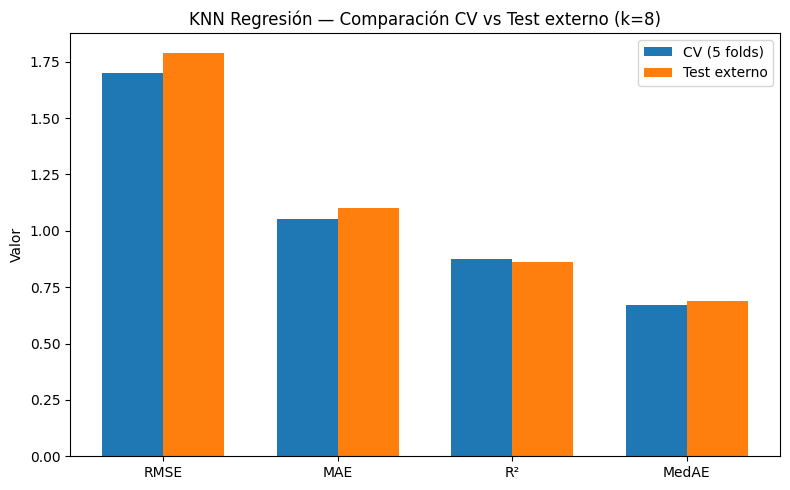

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================
# 1) Tomar las métricas desde variables existentes o usar fallback con tus números
# ============================
try:
    # Si ya tienes summary_df (CV) y las métricas de test (holdout) en variables:
    # best_k = 8  # asegura k=8 si hace falta
    row_cv = summary_df.loc[summary_df['k'] == 8].iloc[0]
    rmse_cv  = float(row_cv['RMSE_mean'])
    mae_cv   = float(row_cv['MAE_mean'])
    r2_cv    = float(row_cv['R2_mean'])
    medae_cv = float(row_cv['MedAE_mean'])

    rmse_test  = float(rmse_test)
    mae_test   = float(mae_test)
    r2_test    = float(r2_test)
    medae_test = float(medae_test)

except Exception:
    # Fallback con tus valores reportados
    rmse_cv, mae_cv, r2_cv, medae_cv = 1.6992, 1.0541, 0.8742, 0.6708
    rmse_test, mae_test, r2_test, medae_test = 1.7889, 1.1016, 0.8610, 0.6909

# ============================
# 2) Construir la tabla comparativa y diferencias
# ============================
data = {
    "Métrica": ["RMSE", "MAE", "R²", "MedAE"],
    "CV (promedio 5 folds, k=8)": [rmse_cv, mae_cv, r2_cv, medae_cv],
    "Test externo (holdout 20%, k=8)": [rmse_test, mae_test, r2_test, medae_test],
}
df_comp = pd.DataFrame(data)
df_comp["Diferencia (Test - CV)"] = df_comp["Test externo (holdout 20%, k=8)"] - df_comp["CV (promedio 5 folds, k=8)"]

# Mostrar tabla en consola
print("\n=== Comparación CV vs Test externo ===")
print(df_comp.to_string(index=False, float_format=lambda x: f"{x:.4f}"))


# ============================
# 3) Gráfico comparativo (barras lado a lado)
# ============================
metrics = df_comp["Métrica"].tolist()
cv_vals = df_comp["CV (promedio 5 folds, k=8)"].values
test_vals = df_comp["Test externo (holdout 20%, k=8)"].values

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, cv_vals, width, label="CV (5 folds)")
plt.bar(x + width/2, test_vals, width, label="Test externo")
plt.xticks(x, metrics)
plt.ylabel("Valor")
plt.title("KNN Regresión — Comparación CV vs Test externo (k=8)")
plt.legend()
plt.tight_layout()
plt.show()


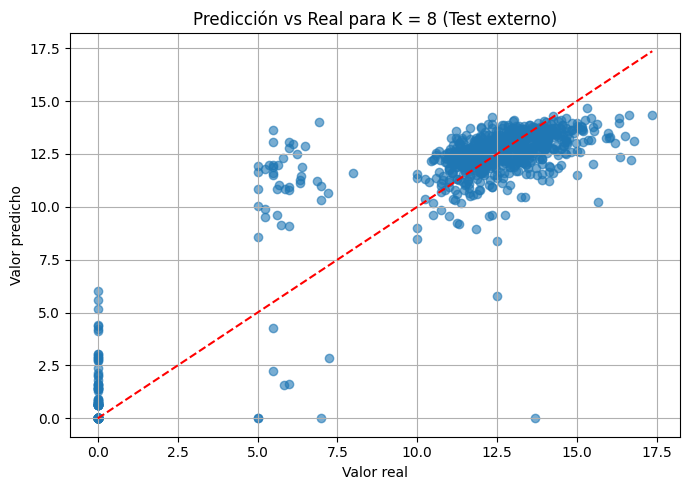

In [15]:
# --- Entrenar y graficar SIN data leakage (usa el holdout externo) ---

# Asegura que best_k exista; si no, toma el mejor del summary_df
try:
    best_k
except NameError:
    best_k = int(summary_df.iloc[0]["k"])

# Entrena SOLO con el conjunto de entrenamiento completo (80%)
best_knn = KNeighborsRegressor(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train_full)

# Predice en el HOLDOUT (20%) — datos nunca vistos en CV
y_pred_holdout = best_knn.predict(X_test_scaled)

# Gráfico Predicho vs Real (HOLDOUT)
plt.figure(figsize=(7, 5))
plt.scatter(y_test_holdout, y_pred_holdout, alpha=0.6)
plt.plot([y_test_holdout.min(), y_test_holdout.max()],
         [y_test_holdout.min(), y_test_holdout.max()], 'r--')
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.title(f"Predicción vs Real para K = {best_k} (Test externo)")
plt.grid(True)
plt.tight_layout()
plt.show()




C:\Users\migue\AppData\Local\Temp\ipykernel_20736\2074621796.py:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


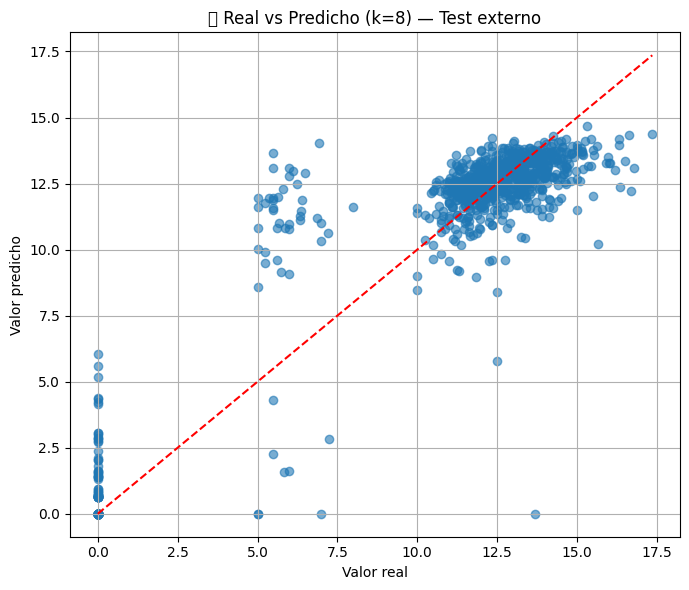

C:\Users\migue\AppData\Local\Temp\ipykernel_20736\2074621796.py:34: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


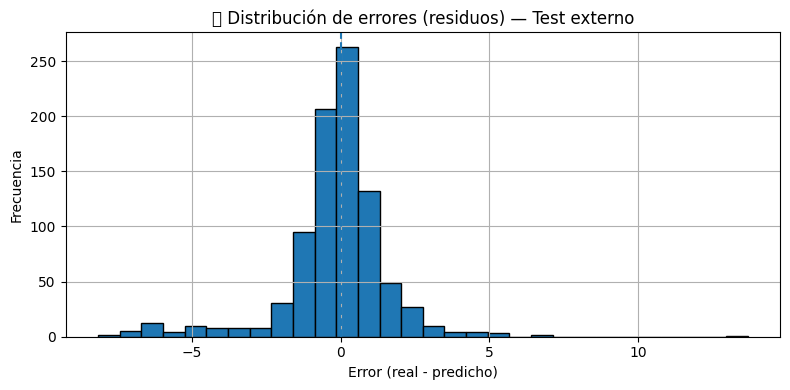

C:\Users\migue\AppData\Local\Temp\ipykernel_20736\2074621796.py:45: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


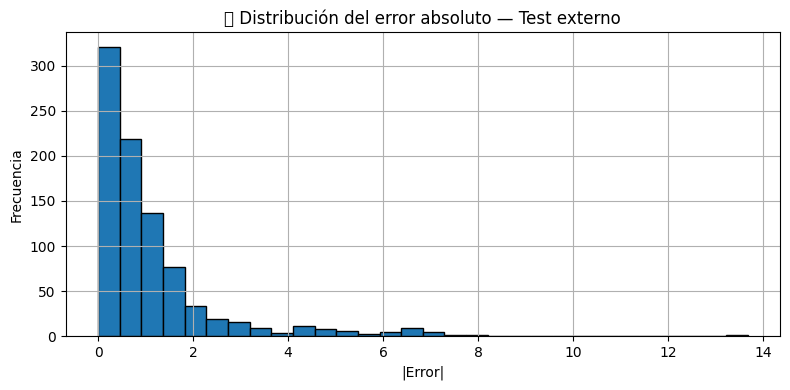

In [16]:
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import numpy as np

# --- Entrenar modelo FINAL en el 80% (train_full) con el k óptimo ---
# (opcional: prueba weights="distance" si quieres dar más peso a vecinos cercanos)
final_knn = KNeighborsRegressor(n_neighbors=best_k)
final_knn.fit(X_train_scaled, y_train_full)

# --- Predecir en el HOLDOUT EXTERNO (20%) ---
y_pred_final = final_knn.predict(X_test_scaled)

# 1) Gráfico Real vs Predicho (holdout)
plt.figure(figsize=(7, 6))
plt.scatter(y_test_holdout, y_pred_final, alpha=0.6)
plt.plot([y_test_holdout.min(), y_test_holdout.max()],
         [y_test_holdout.min(), y_test_holdout.max()], 'r--')
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.title(f"📈 Real vs Predicho (k={best_k}) — Test externo")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Distribución de errores (residuos) en holdout
residuals = y_test_holdout - y_pred_final
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=30, edgecolor='black')
plt.axvline(0, linestyle='--')
plt.title("📉 Distribución de errores (residuos) — Test externo")
plt.xlabel("Error (real - predicho)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Distribución del error absoluto en holdout
abs_errors = np.abs(residuals)
plt.figure(figsize=(8, 4))
plt.hist(abs_errors, bins=30, edgecolor='black')
plt.title("📊 Distribución del error absoluto — Test externo")
plt.xlabel("|Error|")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()



In [17]:
# ==============================================
# KNN Regresión — CV 5-fold (k=1..20) + Holdout 20% (sin fugas)
# ==============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

# --------------------------
# 1) Cargar datos
# --------------------------
df = pd.read_csv("data.csv", sep=";")

# --------------------------
# 2) Variable objetivo: promedio 1er y 2º semestre
# --------------------------
df["Final_Average"] = df[[
    "Curricular units 1st sem (grade)", 
    "Curricular units 2nd sem (grade)"
]].mean(axis=1)

# --------------------------
# 3) Evitar fuga: eliminar TODO 2º semestre + Target + la propia y
# --------------------------
cols_to_exclude = [
    "Target", "Final_Average",
    "Curricular units 2nd sem (grade)", 
    "Curricular units 2nd sem (approved)", 
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 2nd sem (credited)", 
    "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (without evaluations)"
]
X_full = df.drop(columns=cols_to_exclude, errors="ignore").copy()
y_full = df["Final_Average"].values

# --------------------------
# 4) Categóricas (tu lista) y numéricas pre-OHE
# --------------------------
categorical_columns = [
    'Marital status', 'Application mode', 'Application order', 'Course',
    'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
    "Mother's qualification", "Father's qualification",
    "Mother's occupation", "Father's occupation", 'Displaced',
    'Educational special needs', 'Debtor', 'Tuition fees up to date',
    'Gender', 'Scholarship holder', 'International'
]
categorical_columns = [c for c in categorical_columns if c in X_full.columns]

numeric_columns_pre_ohe = X_full.select_dtypes(include=['float64','int64']).columns.tolist()
numeric_columns_pre_ohe = [c for c in numeric_columns_pre_ohe if c not in categorical_columns]

# --------------------------
# 5) HOLDOUT externo 20%
# --------------------------
X_train_full, X_test_holdout, y_train_full, y_test_holdout = train_test_split(
    X_full, y_full, test_size=0.20, random_state=42
)

# --------------------------
# 6) CV manual 5-fold en el 80% (buscar k=1..20)
#    OHE + Escalado dentro del fold (sin fugas)
# --------------------------
k_values = range(1, 21)
cv_results = {k: {"RMSE": [], "MAE": [], "R2": [], "MedAE": []} for k in k_values}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for k in k_values:
    for tr_idx, va_idx in kf.split(X_train_full):
        X_tr_raw = X_train_full.iloc[tr_idx].copy()
        X_va_raw = X_train_full.iloc[va_idx].copy()
        y_tr = y_train_full[tr_idx]
        y_va = y_train_full[va_idx]

        # OHE dentro del fold
        X_tr = pd.get_dummies(X_tr_raw, columns=categorical_columns, drop_first=True)
        X_va = pd.get_dummies(X_va_raw, columns=categorical_columns, drop_first=True)
        X_va = X_va.reindex(columns=X_tr.columns, fill_value=0)

        # Escalado dentro del fold (solo numéricas continuas existentes)
        cols_to_scale = [c for c in numeric_columns_pre_ohe if c in X_tr.columns]
        scaler = StandardScaler()
        X_tr[cols_to_scale] = scaler.fit_transform(X_tr[cols_to_scale])
        X_va[cols_to_scale] = scaler.transform(X_va[cols_to_scale])

        # Modelo y predicción
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_tr, y_tr)
        y_pred = knn.predict(X_va)

        # Métricas del fold
        mse = mean_squared_error(y_va, y_pred)
        cv_results[k]["RMSE"].append(np.sqrt(mse))
        cv_results[k]["MAE"].append(mean_absolute_error(y_va, y_pred))
        cv_results[k]["R2"].append(r2_score(y_va, y_pred))
        cv_results[k]["MedAE"].append(median_absolute_error(y_va, y_pred))

# Resumen por k
summary = []
for k in k_values:
    summary.append({
        "k": k,
        "RMSE_mean": np.mean(cv_results[k]["RMSE"]),
        "RMSE_std":  np.std(cv_results[k]["RMSE"]),
        "MAE_mean":  np.mean(cv_results[k]["MAE"]),
        "R2_mean":   np.mean(cv_results[k]["R2"]),
        "MedAE_mean":np.mean(cv_results[k]["MedAE"]),
    })
summary_df = pd.DataFrame(summary).sort_values(by="RMSE_mean", ascending=True)

print("===== Resumen CV 5-fold en TRAIN (ordenado por RMSE promedio) =====")
print(summary_df.to_string(index=False))

best_k = int(summary_df.iloc[0]["k"])
print(f"\n✅ Mejor k por RMSE promedio (CV en train): {best_k}")

# --------------------------
# 7) Entrenamiento FINAL en todo el 80% y evaluación en HOLDOUT 20%
# --------------------------
# OHE en train_full y test_holdout usando columnas del train
X_train_ohe = pd.get_dummies(X_train_full, columns=categorical_columns, drop_first=True)
X_test_ohe  = pd.get_dummies(X_test_holdout, columns=categorical_columns, drop_first=True)
X_test_ohe  = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

# Escalado final (ajustado SOLO con el train_full)
cols_to_scale_final = [c for c in numeric_columns_pre_ohe if c in X_train_ohe.columns]
scaler_final = StandardScaler()
X_train_scaled = X_train_ohe.copy()
X_test_scaled  = X_test_ohe.copy()
X_train_scaled[cols_to_scale_final] = scaler_final.fit_transform(X_train_scaled[cols_to_scale_final])
X_test_scaled[cols_to_scale_final]  = scaler_final.transform(X_test_scaled[cols_to_scale_final])

# Modelo final y métricas en holdout
knn_final = KNeighborsRegressor(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train_full)
y_pred_test = knn_final.predict(X_test_scaled)

mse_test = mean_squared_error(y_test_holdout, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test  = mean_absolute_error(y_test_holdout, y_pred_test)
r2_test   = r2_score(y_test_holdout, y_pred_test)
medae_test = median_absolute_error(y_test_holdout, y_pred_test)

n_test = len(y_test_holdout)
p = X_test_scaled.shape[1]
r2_adj_test = 1 - (1 - r2_test) * (n_test - 1) / max(n_test - p - 1, 1)

print("\n===== Métricas en HOLDOUT EXTERNO (20%) =====")
print(f"RMSE:    {rmse_test:.4f}")
print(f"MAE:     {mae_test:.4f}")
print(f"R²:      {r2_test:.4f}")
print(f"R²_adj:  {r2_adj_test:.4f}")
print(f"MedAE:   {medae_test:.4f}")




===== Resumen CV 5-fold en TRAIN (ordenado por RMSE promedio) =====
 k  RMSE_mean  RMSE_std  MAE_mean  R2_mean  MedAE_mean
 8   1.699206  0.027630  1.054130 0.874195    0.670791
 9   1.700738  0.030459  1.056765 0.873982    0.659344
10   1.700751  0.029324  1.057884 0.874034    0.649848
11   1.701074  0.022036  1.059829 0.873964    0.636945
 7   1.705818  0.026141  1.056755 0.873234    0.689052
13   1.706670  0.018902  1.068118 0.873207    0.659298
12   1.707412  0.021673  1.062821 0.873013    0.645268
16   1.708865  0.013953  1.073470 0.872959    0.674978
14   1.710717  0.013977  1.071778 0.872646    0.661326
17   1.713130  0.011751  1.078210 0.872335    0.672045
15   1.714662  0.012336  1.076244 0.872073    0.677318
 6   1.716504  0.033356  1.059863 0.871575    0.679683
18   1.717232  0.007974  1.080895 0.871849    0.668324
19   1.719497  0.011367  1.082333 0.871519    0.661837
 5   1.727544  0.034021  1.066015 0.869929    0.680512
20   1.727761  0.018437  1.086901 0.870380    0.6664

C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


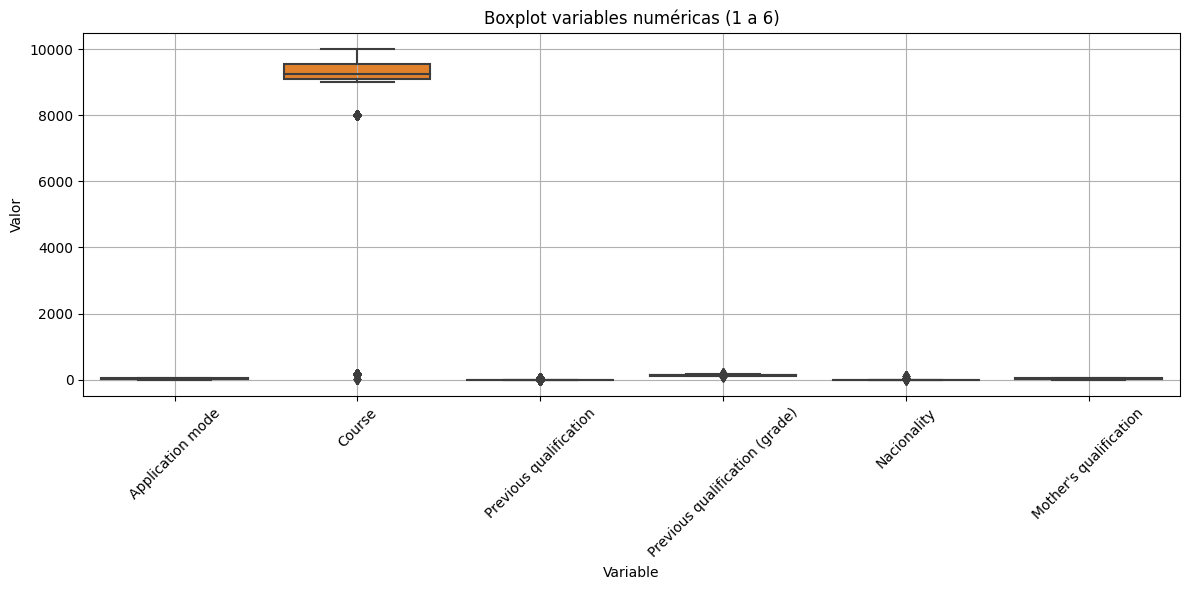

C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


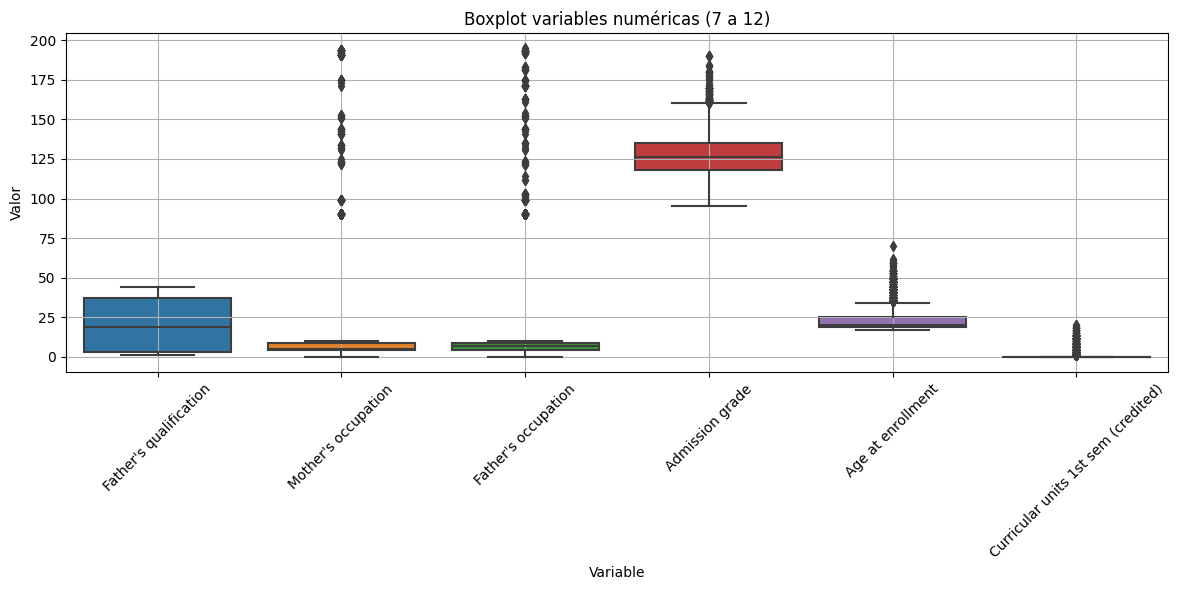

C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


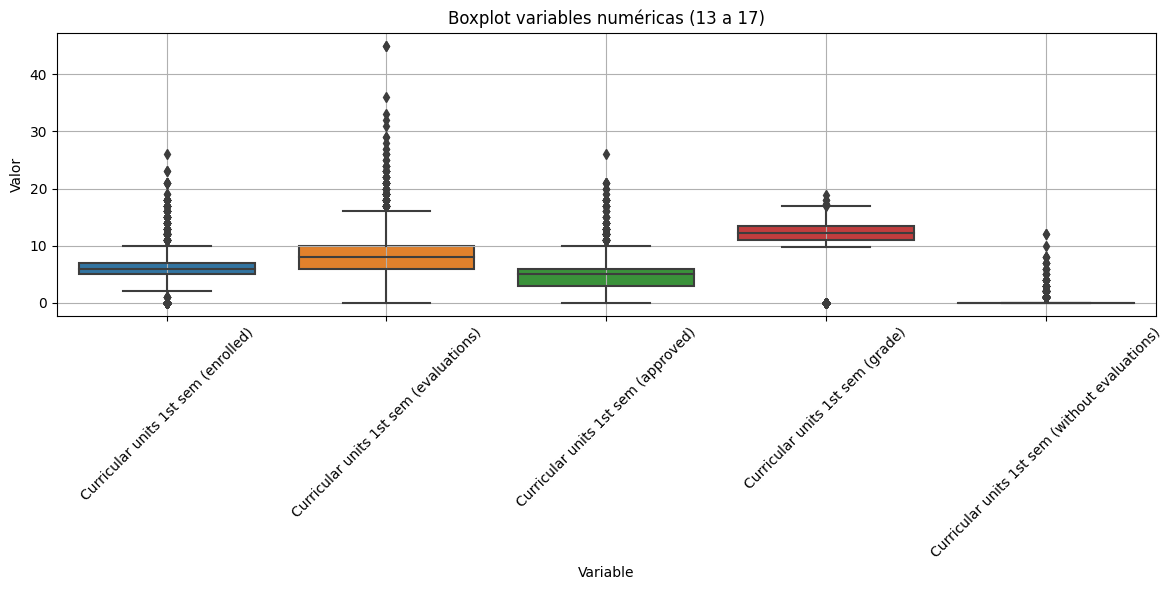


📊 Posibles outliers detectados (valores fuera de [lim_inf, lim_sup]):
Application mode: 0 outliers (lim_inf=-56.00, lim_sup=96.00)
Course: 442 outliers (lim_inf=8378.50, lim_sup=10262.50)
Previous qualification: 707 outliers (lim_inf=1.00, lim_sup=1.00)
Previous qualification (grade): 179 outliers (lim_inf=102.50, lim_sup=162.50)
Nacionality: 110 outliers (lim_inf=1.00, lim_sup=1.00)
Mother's qualification: 0 outliers (lim_inf=-50.50, lim_sup=89.50)
Father's qualification: 0 outliers (lim_inf=-48.00, lim_sup=88.00)
Mother's occupation: 182 outliers (lim_inf=-3.50, lim_sup=16.50)
Father's occupation: 177 outliers (lim_inf=-3.50, lim_sup=16.50)
Admission grade: 86 outliers (lim_inf=92.55, lim_sup=160.15)
Age at enrollment: 441 outliers (lim_inf=10.00, lim_sup=34.00)
Curricular units 1st sem (credited): 577 outliers (lim_inf=0.00, lim_sup=0.00)
Curricular units 1st sem (enrolled): 424 outliers (lim_inf=2.00, lim_sup=10.00)
Curricular units 1st sem (evaluations): 158 outliers (lim_inf=0.0

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Cargar el dataset
df = pd.read_csv("data.csv", sep=";")

# 2. Crear variable objetivo
df["Final_Average"] = df[[
    "Curricular units 1st sem (grade)", 
    "Curricular units 2nd sem (grade)"
]].mean(axis=1)

# 3. Seleccionar columnas numéricas con más de 10 valores únicos
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# 4. Excluir variables no usadas en modelado
excluir = [
    'Final_Average', 'Target',
    "Curricular units 2nd sem (grade)", 
    "Curricular units 2nd sem (approved)", 
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 2nd sem (credited)", 
    "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (without evaluations)"
]
numeric_columns = [col for col in numeric_columns if col not in excluir and df[col].nunique() > 10]

# 5. Función para graficar boxplots y devolver límites IQR
def graficar_y_detectar_outliers(df, columnas, grupo=6):
    limites = {}
    for i in range(0, len(columnas), grupo):
        subset = columnas[i:i+grupo]
        
        # Calcular límites por columna
        for col in subset:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            limites[col] = (lower, upper)
        
        # Graficar
        df_melt = df[subset].melt(var_name='Variable', value_name='Valor')
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df_melt, x='Variable', y='Valor')
        plt.xticks(rotation=45)
        plt.title(f"Boxplot variables numéricas ({i+1} a {i+len(subset)})")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    return limites

# 6. Detectar y mostrar límites
limites_outliers = graficar_y_detectar_outliers(df, numeric_columns)

# 7. Mostrar resumen de columnas con posibles outliers
print("\n📊 Posibles outliers detectados (valores fuera de [lim_inf, lim_sup]):")
for col, (low, high) in limites_outliers.items():
    n_outliers = ((df[col] < low) | (df[col] > high)).sum()
    print(f"{col}: {n_outliers} outliers (lim_inf={low:.2f}, lim_sup={high:.2f})")

# 8. Winsorización opcional (descomenta si quieres aplicar)
# for col, (low, high) in limites_outliers.items():
#     df[col] = np.where(df[col] < low, low, df[col])
#     df[col] = np.where(df[col] > high, high, df[col])



In [21]:
# ==============================================
# Comparación KNN Regresión: Original vs Winsorizado vs Sin Outliers
# - Sin data leakage (OHE + escalado dentro del fold)
# - CV manual 5-fold
# - k = 1..20
# ==============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from scipy.stats.mstats import winsorize

# -----------------------
# 1) Cargar dataset
# -----------------------
df = pd.read_csv("data.csv", sep=";")

# -----------------------
# 2) Crear variable objetivo (promedio 1º y 2º semestre)
# -----------------------
df["Final_Average"] = df[[
    "Curricular units 1st sem (grade)",
    "Curricular units 2nd sem (grade)"
]].mean(axis=1)

# -----------------------
# 3) Evitar fuga: eliminar TODAS las del 2º semestre + Target + la propia y
# -----------------------
cols_to_exclude = [
    "Target", "Final_Average",
    "Curricular units 2nd sem (grade)",
    "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 2nd sem (credited)",
    "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (without evaluations)"
]
X_base = df.drop(columns=cols_to_exclude, errors="ignore")
y_base = df["Final_Average"]  # Series

# -----------------------
# 4) Lista fija de categóricas (filtrada a las que existan)
# -----------------------
categorical_columns_all = [
    'Marital status', 'Application mode', 'Application order', 'Course',
    'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
    "Mother's qualification", "Father's qualification",
    "Mother's occupation", "Father's occupation", 'Displaced',
    'Educational special needs', 'Debtor', 'Tuition fees up to date',
    'Gender', 'Scholarship holder', 'International'
]
categorical_columns_all = [c for c in categorical_columns_all if c in X_base.columns]

# -----------------------
# 5) Funciones de tratamiento de outliers SOLO en numéricas reales
# -----------------------
def get_numeric_real_cols(X, cat_cols):
    # numéricas reales = columnas no listadas como categóricas (y con dtype numérico)
    return [c for c in X.select_dtypes(include=['float64','int64']).columns if c not in cat_cols]

def winsorize_df(X, num_cols, limits=(0.05, 0.05)):
    Xw = X.copy()
    for col in num_cols:
        # winsorize devuelve masked array; convertir a np.array
        Xw[col] = np.asarray(winsorize(Xw[col], limits=limits))
    return Xw

def remove_outliers_df(X, num_cols):
    Xr = X.copy()
    # Construir una máscara global manteniendo filas dentro de IQR en TODAS las numéricas
    mask = pd.Series(True, index=Xr.index)
    for col in num_cols:
        Q1 = Xr[col].quantile(0.25)
        Q3 = Xr[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        mask &= (Xr[col] >= lower) & (Xr[col] <= upper)
    return Xr.loc[mask]

# -----------------------
# 6) Evaluación con CV 5-fold, OHE y escalado DENTRO del fold
# -----------------------
def evaluar_dataset(X_in, y_in, cat_cols):
    """
    - X_in: features del dataset (posiblemente tratado)
    - y_in: Series con el objetivo
    - cat_cols: lista de categóricas a considerar (intersectaremos según existan en X_in)
    """
    # Asegurar alineación (por si X_in fue filtrado por outliers)
    y_in = y_in.loc[X_in.index]

    # Determinar columnas por TIPO para ESTE dataset
    cat_cols = [c for c in cat_cols if c in X_in.columns]
    num_cols = get_numeric_real_cols(X_in, cat_cols)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    resultados = []

    for k in range(1, 21):
        rmse_list, mae_list, r2_list, medae_list = [], [], [], []

        for tr_idx, va_idx in kf.split(X_in):
            X_tr_raw = X_in.iloc[tr_idx].copy()
            X_va_raw = X_in.iloc[va_idx].copy()
            y_tr = y_in.iloc[tr_idx]
            y_va = y_in.iloc[va_idx]

            # OHE dentro del fold (solo columnas categóricas que existan en este fold)
            cats_fold = [c for c in cat_cols if c in X_tr_raw.columns]
            X_tr = pd.get_dummies(X_tr_raw, columns=cats_fold, drop_first=True)
            X_va = pd.get_dummies(X_va_raw, columns=cats_fold, drop_first=True)

            # Alinear columnas (categorías faltantes a 0)
            X_va = X_va.reindex(columns=X_tr.columns, fill_value=0)

            # Escalado SOLO en numéricas reales presentes tras OHE
            cols_to_scale = [c for c in num_cols if c in X_tr.columns]
            scaler = StandardScaler()
            X_tr[cols_to_scale] = scaler.fit_transform(X_tr[cols_to_scale])
            X_va[cols_to_scale] = scaler.transform(X_va[cols_to_scale])

            # Modelo y predicción
            knn = KNeighborsRegressor(n_neighbors=k)
            knn.fit(X_tr, y_tr)
            y_pred = knn.predict(X_va)

            # Métricas
            rmse_list.append(np.sqrt(mean_squared_error(y_va, y_pred)))
            mae_list.append(mean_absolute_error(y_va, y_pred))
            r2_list.append(r2_score(y_va, y_pred))
            medae_list.append(median_absolute_error(y_va, y_pred))

        resultados.append({
            "k": k,
            "RMSE_mean": float(np.mean(rmse_list)),
            "MAE_mean": float(np.mean(mae_list)),
            "R2_mean": float(np.mean(r2_list)),
            "MedAE_mean": float(np.mean(medae_list))
        })

    df_res = pd.DataFrame(resultados).sort_values(by="RMSE_mean", ascending=True)
    best_row = df_res.iloc[0]
    return df_res, int(best_row["k"])

# -----------------------
# 7) Preparar datasets (Original / Winsorizado / Sin Outliers)
# -----------------------
# columnas numéricas reales del X_base para tratamientos
num_cols_base = get_numeric_real_cols(X_base, categorical_columns_all)

datasets = {
    "Original": X_base,
    "Winsorizado": winsorize_df(X_base, num_cols_base, limits=(0.05, 0.05)),  # 5%-5% por defecto
    "Sin Outliers": remove_outliers_df(X_base, num_cols_base)
}

# -----------------------
# 8) Evaluar y comparar
# -----------------------
comparacion_final = []
detalles_por_ds = {}

for nombre, Xv in datasets.items():
    print(f"\n=== Evaluando dataset: {nombre} ===")
    # Recalcular y para el caso "Sin Outliers" (por si filtró filas)
    yv = y_base.loc[Xv.index]
    # Filtrar categóricas disponibles en ESTA versión de X
    cat_v = [c for c in categorical_columns_all if c in Xv.columns]

    df_res, best_k = evaluar_dataset(Xv, yv, cat_v)
    detalles_por_ds[nombre] = df_res  # por si quieres ver la curva RMSE vs k luego

    print(df_res.head(3).to_string(index=False))  # top-3 para revisar
    print(f"Mejor k: {best_k} | RMSE: {df_res.iloc[0]['RMSE_mean']:.4f}")

    comparacion_final.append({
        "Dataset": nombre,
        "Mejor_k": best_k,
        "RMSE": df_res.iloc[0]["RMSE_mean"],
        "MAE": df_res.iloc[0]["MAE_mean"],
        "R2": df_res.iloc[0]["R2_mean"],
        "MedAE": df_res.iloc[0]["MedAE_mean"]
    })

df_comparacion = pd.DataFrame(comparacion_final).sort_values(by="RMSE")
print("\n📊 Comparación final entre datasets (ordenado por RMSE):")
print(df_comparacion.to_string(index=False))



=== Evaluando dataset: Original ===
 k  RMSE_mean  MAE_mean  R2_mean  MedAE_mean
 9   1.679730  1.039846 0.876763    0.654618
10   1.683860  1.044105 0.876197    0.653193
 8   1.685886  1.042982 0.875783    0.665716
Mejor k: 9 | RMSE: 1.6797

=== Evaluando dataset: Winsorizado ===
 k  RMSE_mean  MAE_mean  R2_mean  MedAE_mean
11   1.636199  1.019540 0.883280    0.643260
10   1.638638  1.017635 0.882868    0.639433
12   1.642213  1.024382 0.882417    0.644198
Mejor k: 11 | RMSE: 1.6362

=== Evaluando dataset: Sin Outliers ===
 k  RMSE_mean  MAE_mean  R2_mean  MedAE_mean
15   1.331213  0.761295 0.477004    0.470343
14   1.331234  0.762547 0.477045    0.469394
20   1.331344  0.756286 0.477172    0.464308
Mejor k: 15 | RMSE: 1.3312

📊 Comparación final entre datasets (ordenado por RMSE):
     Dataset  Mejor_k     RMSE      MAE       R2    MedAE
Sin Outliers       15 1.331213 0.761295 0.477004 0.470343
 Winsorizado       11 1.636199 1.019540 0.883280 0.643260
    Original        9 1.679730 

===== Métricas en HOLDOUT EXTERNO (Winsorizado, k=11) =====
RMSE:   1.6802
MAE:    1.0537
R²:     0.8774
MedAE:  0.6534


C:\Users\migue\AppData\Local\Temp\ipykernel_20736\2054813078.py:88: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.grid(True); plt.tight_layout(); plt.show()
C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


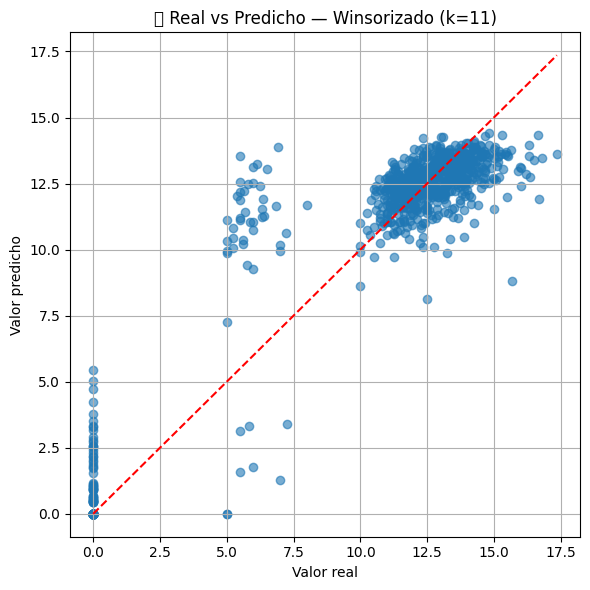

C:\Users\migue\AppData\Local\Temp\ipykernel_20736\2054813078.py:96: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.grid(True); plt.tight_layout(); plt.show()
C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


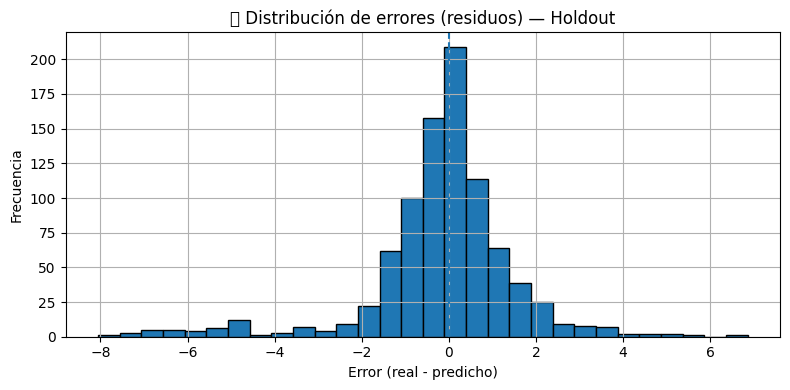

In [23]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt

# --- 1) Partimos de df ya cargado y Final_Average creado ---
# Si no lo tienes, descomenta estas dos líneas:
# df = pd.read_csv("data.csv", sep=";")
# df["Final_Average"] = df[["Curricular units 1st sem (grade)", "Curricular units 2nd sem (grade)"]].mean(axis=1)

# --- 2) Quitar columnas que causan fuga (todas las del 2º semestre + Target + la propia y) ---
cols_to_exclude = [
    "Target", "Final_Average",
    "Curricular units 2nd sem (grade)",
    "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 2nd sem (credited)",
    "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (without evaluations)"
]
X_base = df.drop(columns=cols_to_exclude, errors="ignore").copy()
y = df["Final_Average"].copy()

# --- 3) Lista fija de categóricas (filtrada a las que existan) ---
categorical_columns_all = [
    'Marital status', 'Application mode', 'Application order', 'Course',
    'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
    "Mother's qualification", "Father's qualification",
    "Mother's occupation", "Father's occupation", 'Displaced',
    'Educational special needs', 'Debtor', 'Tuition fees up to date',
    'Gender', 'Scholarship holder', 'International'
]
categorical_columns_all = [c for c in categorical_columns_all if c in X_base.columns]

# Numéricas reales (para winsorizar y luego escalar)
num_cols_base = [c for c in X_base.select_dtypes(include=['float64','int64']).columns if c not in categorical_columns_all]

# --- 4) Construir X_winsor (5%–5% por defecto) ---
X_winsor = X_base.copy()
for col in num_cols_base:
    X_winsor[col] = np.asarray(winsorize(X_winsor[col], limits=(0.05, 0.05)))

# --- 5) Split holdout externo 20% (sin fugas) ---
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_winsor, y, test_size=0.20, random_state=42
)

# --- 6) OHE SOLO con TRAIN y alinear TEST ---
cats_train = [c for c in categorical_columns_all if c in X_train_raw.columns]
X_train_ohe = pd.get_dummies(X_train_raw, columns=cats_train, drop_first=True)
X_test_ohe  = pd.get_dummies(X_test_raw,  columns=cats_train, drop_first=True)
X_test_ohe  = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

# --- 7) Escalado SOLO en numéricas reales presentes (no escalar dummies) ---
cols_to_scale = [c for c in num_cols_base if c in X_train_ohe.columns]
scaler = StandardScaler()
X_train = X_train_ohe.copy()
X_test  = X_test_ohe.copy()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale]  = scaler.transform(X_test[cols_to_scale])

# --- 8) Entrenar KNN final con k=11 (mejor en winsorizado) y evaluar ---
knn = KNeighborsRegressor(n_neighbors=11)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
mae  = float(mean_absolute_error(y_test, y_pred))
r2   = float(r2_score(y_test, y_pred))
medae = float(median_absolute_error(y_test, y_pred))

print("===== Métricas en HOLDOUT EXTERNO (Winsorizado, k=11) =====")
print(f"RMSE:   {rmse:.4f}")
print(f"MAE:    {mae:.4f}")
print(f"R²:     {r2:.4f}")
print(f"MedAE:  {medae:.4f}")

# --- 9) Gráficos (sin fugas, en test externo) ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valor real"); plt.ylabel("Valor predicho")
plt.title("📈 Real vs Predicho — Winsorizado (k=11)")
plt.grid(True); plt.tight_layout(); plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(8,4))
plt.hist(residuals, bins=30, edgecolor='black')
plt.axvline(0, linestyle='--')
plt.title("📉 Distribución de errores (residuos) — Holdout")
plt.xlabel("Error (real - predicho)"); plt.ylabel("Frecuencia")
plt.grid(True); plt.tight_layout(); plt.show()



  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ----- ---------------------------------- 1.3/9.7 MB 13.4 MB/s eta 0:00:01
   -------------------------- ------------- 6.3/9.7 MB 20.3 MB/s eta 0:00:01
   ---------------------------------------- 9.7/9.7 MB 22.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.4 MB ? eta -:--:--
   -------------------- ------------------- 5.8/11.4 MB 29.4 MB/s eta 0:00:01
   -------------------------------------- - 11.0/11.4 MB 27.6 MB/s eta 0:00:01
   ---------------------------------------- 11.4/11.4 MB 27.3 MB/s eta 0:00:00

   ---------------------------------------- 0/3 [patsy]
  Attempting uninstall: pandas
   ---------------------------------------- 0/3 [patsy]
    Found existing installation: pandas 2.1.0
   ---------------------------------------- 0/3 [patsy]
   ------------- -------------------------- 1/3 [pandas]
   ------------- -------------------------- 1/3 [pandas]
   ------------- -----------------

C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\migue\AppData\Local\Temp\ipykernel_20736\1529436941.py:65: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


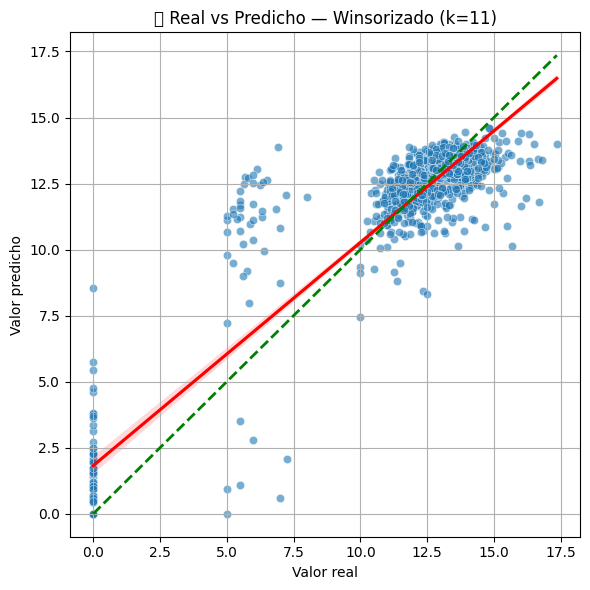

C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\migue\AppData\Local\Temp\ipykernel_20736\1529436941.py:77: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


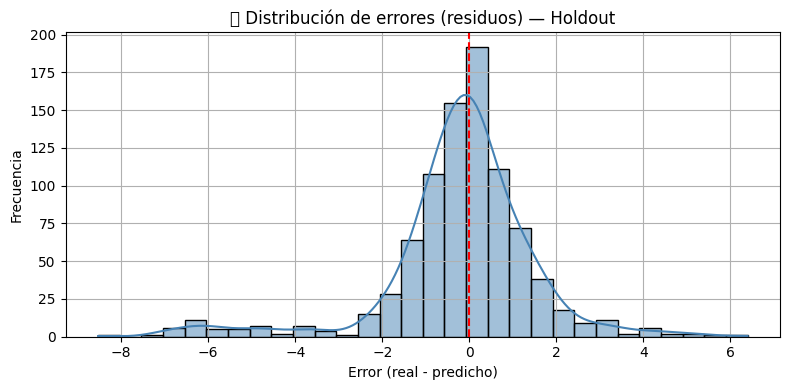

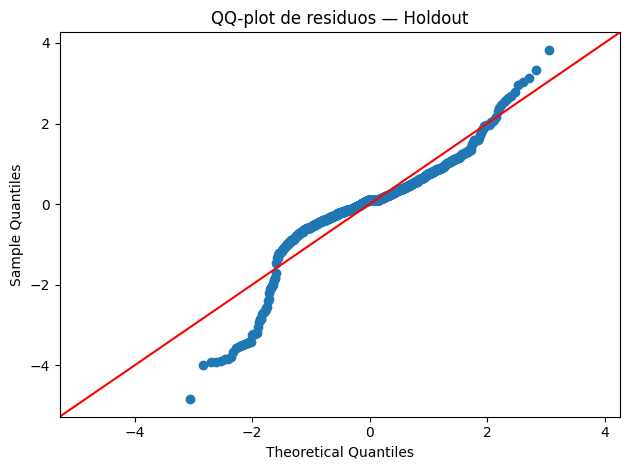

C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


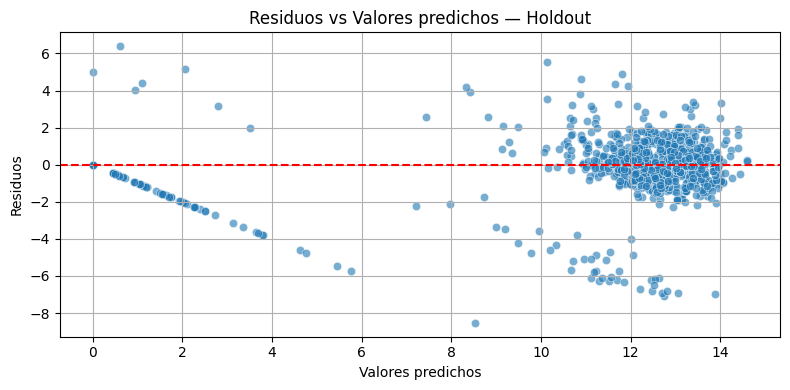

In [26]:
import pandas as pd
!pip install statsmodels
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
)

# 1. División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_winsor, y, test_size=0.2, random_state=42
)

# 2. One-hot encoding y escalado SOLO en TRAIN
categorical_columns = base_categoricals + ['Course', 'Nacionality']
numeric_columns = X_winsor.select_dtypes(include=['float64', 'int64']).columns.tolist()

X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

# Alinear columnas
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Escalado
scaler = StandardScaler()
columns_to_scale = [col for col in numeric_columns if col in X_train.columns]
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

# 3. Entrenar modelo final (k=11)
model = KNeighborsRegressor(n_neighbors=11)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 4. Calcular métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"===== Métricas en HOLDOUT EXTERNO (Winsorizado, k=11) =====")
print(f"RMSE:   {rmse:.4f}")
print(f"MAE:    {mae:.4f}")
print(f"R²:     {r2:.4f}")
print(f"MedAE:  {medae:.4f}")

# =======================
# 5. Visualizaciones
# =======================

# 5.1 Real vs Predicho con línea de regresión
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
sns.regplot(x=y_test, y=y_pred, scatter=False, color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g--', lw=2)
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.title(f"📈 Real vs Predicho — Winsorizado (k=11)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5.2 Distribución de residuos
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True, color='steelblue')
plt.axvline(0, color='red', linestyle='--')
plt.title("📉 Distribución de errores (residuos) — Holdout")
plt.xlabel("Error (real - predicho)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5.3 QQ-plot para normalidad de residuos
sm.qqplot(residuals, line='45', fit=True)
plt.title("QQ-plot de residuos — Holdout")
plt.tight_layout()
plt.show()

# 5.4 Residuos vs Valores predichos
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuos vs Valores predichos — Holdout")
plt.xlabel("Valores predichos")
plt.ylabel("Residuos")
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd

# 📌 Resultados de la validación cruzada (Winsorizado, k=11)
cv_results = {
    "RMSE": 1.6362,  # Valor promedio de la CV
    "MAE": 1.0195,
    "R²": 0.8833,
    "MedAE": 0.6433
}

# 📌 Resultados del Holdout externo
holdout_results = {
    "RMSE": 1.7320,
    "MAE": 1.1010,
    "R²": 0.8697,
    "MedAE": 0.6977
}

# 📊 Crear DataFrame comparativo
comparacion = pd.DataFrame([cv_results, holdout_results], index=["Validación Cruzada", "Holdout Externo"])
comparacion


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\pandas\core\frame.py", line 1178, in _repr_html_
  File "C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\pandas\io\formats\format.py", line 1074, in to_html
  File "C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "C:\Users\migue\miniconda3\envs\ml_venv\lib\site-packages\pandas\io\formats\html.py", line 94, in render
    self._write_table()
  File "C:\Users\migue\

                      RMSE     MAE      R²   MedAE
Validación Cruzada  1.6362  1.0195  0.8833  0.6433
Holdout Externo     1.7320  1.1010  0.8697  0.6977

## 📌 Conclusiones del modelo de regresión KNN

- Se evaluaron tres variantes del dataset: **Original**, **Winsorizado** y **Sin Outliers**.  
  El análisis comparativo con validación cruzada (5 splits) mostró que el dataset **Winsorizado**
  con **k=11** obtuvo el mejor equilibrio entre error y capacidad predictiva.

- En validación cruzada, el modelo logró:
  - **RMSE:** 1.6362
  - **MAE:** 1.0195
  - **R²:** 0.8833
  - **MedAE:** 0.6433

- En el **holdout externo** (20% de datos no usados en entrenamiento), los resultados fueron:
  - **RMSE:** 1.7320
  - **MAE:** 1.1010
  - **R²:** 0.8697
  - **MedAE:** 0.6977

- La ligera caída en rendimiento entre CV y holdout indica que el modelo mantiene buena capacidad de generalización, sin evidencias de sobreajuste.

- Los análisis gráficos (residuos, QQ-plot y real vs. predicho) muestran que:
  - Los errores se distribuyen aproximadamente de forma simétrica.
  - Existe una relación lineal consistente entre valores reales y predichos.
  - No se detectan patrones evidentes en los residuos que sugieran problemas de especificación del modelo.

✅ **Conclusión final:** El modelo KNN con **k=11** entrenado sobre el dataset winsorizado es consistente, estable y adecuado para predecir el promedio final esperado de los estudiantes en este conjunto de datos.
